In [9]:
from __future__ import division

import pandas as pd
import numpy as np
import sframe
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
ROUNDS = 500

In [6]:
train = sframe.load_sframe('train_features.sf').to_numpy()
test = sframe.load_sframe('test_features.sf').to_numpy()
target = pd.read_csv('target.csv')['is_duplicate'].as_matrix()
ids = pd.read_csv('ids.csv')

In [7]:
params ={
    'objective'   : 'binary:logistic',
    'eval_metric' : 'logloss',
    'eta'         : 0.11,
    'max_depth'   : 5,
    'silent'      : 1,
    'seed'        : SEED}

skf = StratifiedKFold(shuffle=True, n_splits=5, random_state=SEED)

In [8]:
X_test = xgb.DMatrix(test)

submissions = []
evals_results = []

for train_index, test_index in skf.split(train, target):
    print("TRAIN:", train_index[:5], "TEST:", test_index[:5])
    X, X_val = train[train_index], train[test_index]
    y, y_val = target[train_index], target[test_index]
    
    X = xgb.DMatrix(X, label=y)
    X_val = xgb.DMatrix(X_val, label=y_val)
    
    watchlist = [(X,'train'), (X_val,'eval')]
    evals_result = {}
    model = xgb.train(params, X,
                      num_boost_round = ROUNDS,
                      evals = watchlist,
                      evals_result = evals_result,
                      verbose_eval = 100) 
    
    submission = model.predict(X_test)
    submissions.append(submission)
    evals_results.append(evals_result)

('TRAIN:', array([0, 1, 2, 3, 5]), 'TEST:', array([ 4,  8, 19, 21, 34]))
[0]	train-logloss:0.662559	eval-logloss:0.66266
[100]	train-logloss:0.477667	eval-logloss:0.480764
[200]	train-logloss:0.468215	eval-logloss:0.474569
[300]	train-logloss:0.461275	eval-logloss:0.47122
[400]	train-logloss:0.455979	eval-logloss:0.468867
[499]	train-logloss:0.451382	eval-logloss:0.466966
('TRAIN:', array([2, 3, 4, 5, 6]), 'TEST:', array([ 0,  1, 12, 18, 30]))
[0]	train-logloss:0.662456	eval-logloss:0.662712
[100]	train-logloss:0.476581	eval-logloss:0.481786
[200]	train-logloss:0.467215	eval-logloss:0.476203
[300]	train-logloss:0.460214	eval-logloss:0.472817
[400]	train-logloss:0.455197	eval-logloss:0.470909
[499]	train-logloss:0.451179	eval-logloss:0.469548
('TRAIN:', array([0, 1, 2, 4, 5]), 'TEST:', array([ 3, 11, 13, 33, 35]))
[0]	train-logloss:0.662575	eval-logloss:0.66267
[100]	train-logloss:0.477031	eval-logloss:0.480307
[200]	train-logloss:0.46779	eval-logloss:0.474134
[300]	train-logloss:0.4612

(0.46, 0.5)

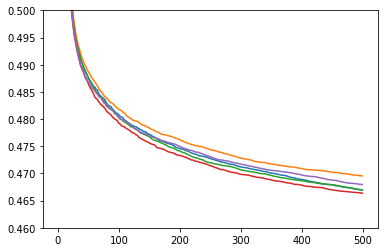

In [18]:
for e in evals_results:
    plt.plot(e['eval']['logloss'])

plt.ylim((0.46, 0.5))

In [19]:
evals = []
for e in evals_results:
    evals.append(e['eval']['logloss'][-1])
evals

[0.466966, 0.469548, 0.466946, 0.466368, 0.467974]

In [27]:
np.mean(evals)

0.46756039999999999

In [20]:
s = np.mean(np.vstack(submissions), axis = 0)
s

array([ 0.20783973,  0.64032972,  0.6190666 , ...,  0.2304883 ,
        0.34870666,  0.19189468], dtype=float32)

In [24]:
ids['is_duplicate'] = s
ids.to_csv('00 submission xgb.csv', index = False)

In [139]:
true_duplicates = pd.read_csv('true_duplicates.csv')

In [140]:
true_duplicates.

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [ ]:
# # author: alijs
# import numpy as np
# import pandas as pd
# import xgboost as xgb
# import datetime
# import operator
# from sklearn.cross_validation import train_test_split
# from collections import Counter
# from nltk.corpus import stopwords
# import matplotlib.pyplot as plt
# from pylab import plot, show, subplot, specgram, imshow, savefig

RS = 12357
ROUNDS = 500

print("Started")
np.random.seed(RS)
input_folder = '../input/'

def train_xgb(X, y, params):
	print("Will train XGB for {} rounds, RandomSeed: {}".format(ROUNDS, RS))
	x, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RS)

	xg_train = xgb.DMatrix(x, label=y_train)
	xg_val = xgb.DMatrix(X_val, label=y_val)

	watchlist  = [(xg_train,'train'), (xg_val,'eval')]
	return xgb.train(params, xg_train, ROUNDS, watchlist)

def predict_xgb(clr, X_test):
	return clr.predict(xgb.DMatrix(X_test))

def create_feature_map(features):
	outfile = open('xgb.fmap', 'w')
	i = 0
	for feat in features:
		outfile.write('{0}\t{1}\tq\n'.format(i, feat))
		i = i + 1
	outfile.close()

def main():


	df_train = pd.read_csv(input_folder + 'train.csv')
	df_test  = pd.read_csv(input_folder + 'test.csv')
	print("Original data: X_train: {}, X_test: {}".format(df_train.shape, df_test.shape))

	print("Features processing, be patient...")

	# If a word appears only once, we ignore it completely (likely a typo)
	# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
	def get_weight(count, eps=10000, min_count=2):
		return 0 if count < min_count else 1 / (count + eps)

	train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
	words = (" ".join(train_qs)).lower().split()
	counts = Counter(words)
	weights = {word: get_weight(count) for word, count in counts.items()}

	stops = set(stopwords.words("english"))
	def word_shares(row):
		q1 = set(str(row['question1']).lower().split())
		q1words = q1.difference(stops)
		if len(q1words) == 0:
			return '0:0:0:0:0'

		q2 = set(str(row['question2']).lower().split())
		q2words = q2.difference(stops)
		if len(q2words) == 0:
			return '0:0:0:0:0'

		q1stops = q1.intersection(stops)
		q2stops = q2.intersection(stops)

		shared_words = q1words.intersection(q2words)
		shared_weights = [weights.get(w, 0) for w in shared_words]
		total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
		
		R1 = np.sum(shared_weights) / np.sum(total_weights) #tfidf share
		R2 = len(shared_words) / (len(q1words) + len(q2words)) #count share
		R31 = len(q1stops) / len(q1words) #stops in q1
		R32 = len(q2stops) / len(q2words) #stops in q2
		return '{}:{}:{}:{}:{}'.format(R1, R2, len(shared_words), R31, R32)

	df = pd.concat([df_train, df_test])
	df['word_shares'] = df.apply(word_shares, axis=1, raw=True)

	x = pd.DataFrame()

	x['word_match']       = df['word_shares'].apply(lambda x: float(x.split(':')[0]))
	x['tfidf_word_match'] = df['word_shares'].apply(lambda x: float(x.split(':')[1]))
	x['shared_count']     = df['word_shares'].apply(lambda x: float(x.split(':')[2]))

	x['stops1_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[3]))
	x['stops2_ratio']     = df['word_shares'].apply(lambda x: float(x.split(':')[4]))
	x['diff_stops_r']     = x['stops1_ratio'] - x['stops2_ratio']

	x['len_q1'] = df['question1'].apply(lambda x: len(str(x)))
	x['len_q2'] = df['question2'].apply(lambda x: len(str(x)))
	x['diff_len'] = x['len_q1'] - x['len_q2']

	x['len_char_q1'] = df['question1'].apply(lambda x: len(str(x).replace(' ', '')))
	x['len_char_q2'] = df['question2'].apply(lambda x: len(str(x).replace(' ', '')))
	x['diff_len_char'] = x['len_char_q1'] - x['len_char_q2']

	x['len_word_q1'] = df['question1'].apply(lambda x: len(str(x).split()))
	x['len_word_q2'] = df['question2'].apply(lambda x: len(str(x).split()))
	x['diff_len_word'] = x['len_word_q1'] - x['len_word_q2']

	x['avg_world_len1'] = x['len_char_q1'] / x['len_word_q1']
	x['avg_world_len2'] = x['len_char_q2'] / x['len_word_q2']
	x['diff_avg_word'] = x['avg_world_len1'] - x['avg_world_len2']

	x['exactly_same'] = (df['question1'] == df['question2']).astype(int)
	x['duplicated'] = df.duplicated(['question1','question2']).astype(int)

	#... YOUR FEATURES HERE ...
	
	feature_names = list(x.columns.values)
	create_feature_map(feature_names)
	print("Features: {}".format(feature_names))

	x_train = x[:df_train.shape[0]]
	x_test  = x[df_train.shape[0]:]
	y_train = df_train['is_duplicate'].values
	del x, df_train

	if 1: # Now we oversample the negative class - on your own risk of overfitting!
		pos_train = x_train[y_train == 1]
		neg_train = x_train[y_train == 0]

		print("Oversampling started for proportion: {}".format(len(pos_train) / (len(pos_train) + len(neg_train))))
		p = 0.165
		scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
		while scale > 1:
			neg_train = pd.concat([neg_train, neg_train])
			scale -=1
		neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
		print("Oversampling done, new proportion: {}".format(len(pos_train) / (len(pos_train) + len(neg_train))))

		x_train = pd.concat([pos_train, neg_train])
		y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
		del pos_train, neg_train
	
	print("Training data: X_train: {}, Y_train: {}, X_test: {}".format(x_train.shape, len(y_train), x_test.shape))
	clr = train_xgb(x_train, y_train, params)
	preds = predict_xgb(clr, x_test)

	print("Writing output...")
	sub = pd.DataFrame()
	sub['test_id'] = df_test['test_id']
	sub['is_duplicate'] = preds
	sub.to_csv("xgb_seed{}_n{}.csv".format(RS, ROUNDS), index=False)

	print("Features importances...")
	importance = clr.get_fscore(fmap='xgb.fmap')
	importance = sorted(importance.items(), key=operator.itemgetter(1))
	ft = pd.DataFrame(importance, columns=['feature', 'fscore'])

	ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
	plt.gcf().savefig('features_importance.png')

main()
print("Done.")

In [56]:
submission       = pd.DataFrame.from_items([('test_id', ids), ('is_duplicate', preds)])
submission_zeros = pd.DataFrame.from_items([('test_id', ids), ('is_duplicate', np.zeros(len(ids)))])
submission_ones  = pd.DataFrame.from_items([('test_id', ids), ('is_duplicate', np.ones(len(ids)))])